In [1]:
import numpy as np
import pandas as pd
import copy
from matplotlib import pyplot as plt
from matplotlib import cm

In [2]:
def center_data(x):
    x_mean = np.mean(x, axis=0)
    x_center = np.subtract(x, x_mean)
    
    return x_center, x_mean



def standardize_data(x):
    x_center, x_mean = center_data(x)
    x_std = np.std(x_center, axis=0)
    x_norm = np.divide(x_center, x_std)
    
    return x_norm, x_std, x_mean



def to_categorical(x):
    #Find the unique values in the vector and index them
    values, index = np.unique(x, return_inverse=True)
    rows = index.shape[0]
    cols = values.shape[0]
    
    #Set a matrix to store the one-hot encoding
    Y = np.zeros((rows,cols))
    
    #Set the value of the class of a given observation to 1
    for i in range(rows):
        Y[i][index[i]] = 1
        
    return Y, values
    
    

def import_norm_data(train_filename, test_filename):
    #Importing the dataframes from CSV files
    train_df = pd.read_csv(train_filename)
    test_df = pd.read_csv(test_filename)
    
    #Extract the training response from the CSV
    y_train = train_df.iloc[:,-1]
    y_train = y_train.to_numpy()
    
    #Extract the observations from the CSV and standardize them
    x_train = train_df.iloc[:,:-1]
    x_train = x_train.to_numpy()
    x_train_norm, x_train_std, x_train_mean = standardize_data(x_train)
    
    #Extract the test response from the CSV
    y_test = test_df.iloc[:,-1]
    y_test = y_test.to_numpy()
    
    #Extract the observations from the CSV and standardize them using parameters from the training set
    x_test = test_df.iloc[:,:-1]
    x_test = x_test.to_numpy()
    x_test_cent = np.subtract(x_test, x_train_mean)
    x_test_norm = np.divide(x_test_cent, x_train_std)
    
    return y_train, x_train_norm, y_test, x_test_norm

In [7]:
def logistic_regression(X, Y, lamb, alpha, epoch):
    #Add a column of 1s for beta0
    ones = np.ones((X.shape[0], 1))
    X = np.column_stack((ones, X))
    
    #Initialize B to zeros for equal probability
    B = np.zeros((X.shape[1], Y.shape[1]))
    
    for i in range(epoch):
        #Calculate the sigmoid
        U = np.exp(np.matmul(X, B))
        U_sum = np.sum(U, axis=1)
        U_sum = U_sum.reshape((U.shape[0], 1))
        P = np.divide(U, U_sum)
        
        #Matrix to remove beta0
        Z = np.zeros(B.shape)
        Z[0] = B[0]
        
        #Calculating update for B
        cost_gradient = np.matmul(X.T, np.subtract(Y, P))
        ridge_penalty_gradient = np.multiply(2*lamb, np.subtract(B, Z))
        B = np.add(B, np.multiply(alpha, np.subtract(cost_gradient, ridge_penalty_gradient)))
    
    return B



def predict(B, X):
    #Add a column of 1s for beta0
    ones = np.ones((X.shape[0], 1))
    X_1 = np.column_stack((ones, X))
    
    #Calculate the probability using the sigmoid
    U = np.exp(np.matmul(X_1, B))
    U_sum = np.sum(U, axis=1)
    U_sum = U_sum.reshape((U.shape[0], 1))
    P = np.divide(U, U_sum)
    
    return P
    

    
def categorical_cross_entropy(B, X, Y):
    #Get the probability predictions
    P = predict(B, X)
    
    #Calculate the categorical cross entropy loss
    CCE_loss = -np.divide(np.sum(np.multiply(np.log10(P), Y)), X.shape[0])
    
    return CCE_loss



def k_fold_cv(X, Y, n, lamb, alpha, epoch):
    #An array to store the CCE loss of each run
    results = []
    
    #Zipping the data, shuffling it to randomize it, and then splitting the data into equal chunks
    data = np.column_stack((X, Y))
    np.random.shuffle(data)
    data = np.array_split(data, n, axis=0)
    
    #For each split...
    for i, split in enumerate(data):
        #Separate response and feature validation sets from the ith split
        y_valid = split[:,-1]   
        Y_valid, _ = to_categorical(y_valid)
        x_valid = np.delete(split, -1, axis=1)
        x_valid = x_valid.astype(float)
        
        #Combine the remaining chunks
        train_data_list = data[:i] + data[i+1:]
        train_data = train_data_list[0]
        for j in range(1,len(train_data_list)):
            train_data = np.concatenate((train_data, train_data_list[j]), axis=0)
        
        #Separate response and feature training sets from the rest of the data
        y_train = train_data[:,-1]
        Y_train, _ = to_categorical(y_train)
        x_train = train_data[:,:-1]
        x_train = x_train.astype(float)
        
        #Perform the regression and obtain beta values
        B = logistic_regression(x_train, Y_train, lamb, alpha, epoch)
        
        #Evaluate the regression
        error = categorical_cross_entropy(B, x_valid, Y_valid)
        results.append(error)
    
    #Find the CCE loss of the k-fold cross validation
    cv_CCE = (1/n)*(sum(results))
    
    return cv_CCE, B

In [4]:
#Setting the paths for both the training CSV file and test CSV file
train_path = 'TrainingData_N183_p10.csv'
test_path = 'TestData_N111_p10.csv'

#Importing and normalizing the data
y_train, x_train, y_test, x_test = import_norm_data(train_path, test_path)

#Performing one-hot encoding on the responses
Y, labels = to_categorical(y_train)

#Setting some parameters to run the regression
alpha = 0.00001
epochs = 10000
lambs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

lamb_log = np.log10(lambs)
lamb_log_smooth = np.linspace(lamb_log.min(), lamb_log.max(), 500)
    
#Setting equally-spaced color values
color_spacing = np.linspace(0,1,x_train.shape[1])
colors = [cm.rainbow(lamb_log_smooth) for lamb_log_smooth in color_spacing]

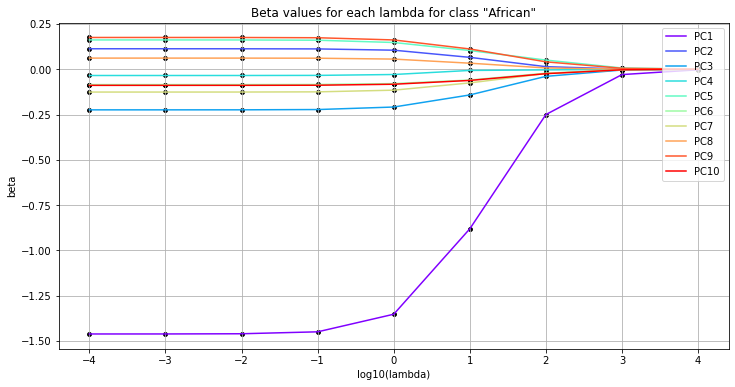

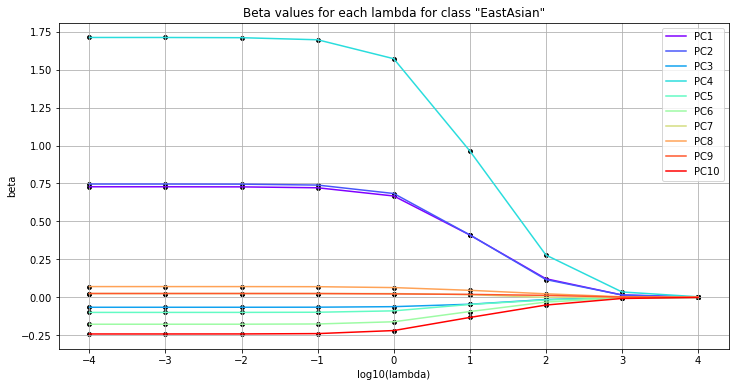

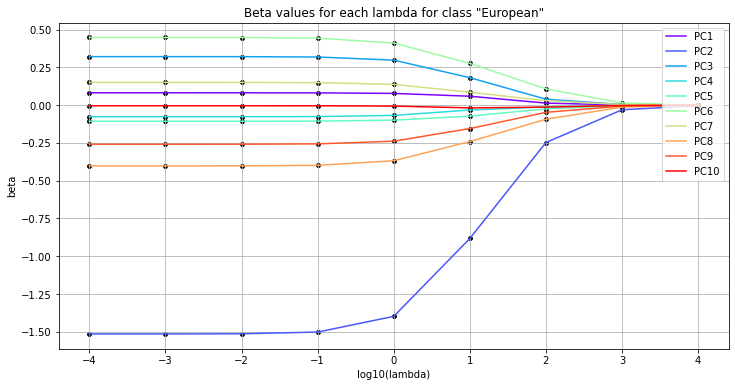

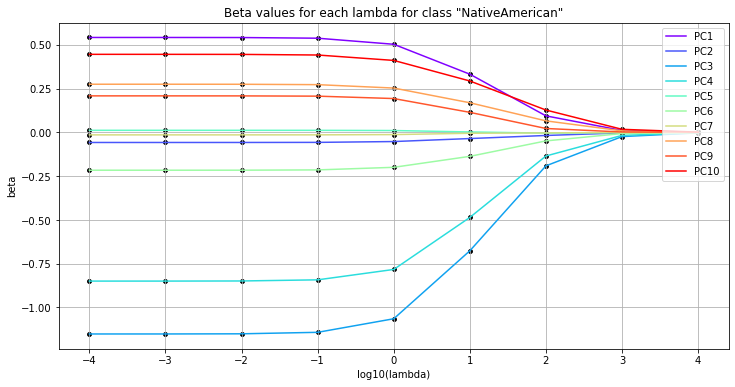

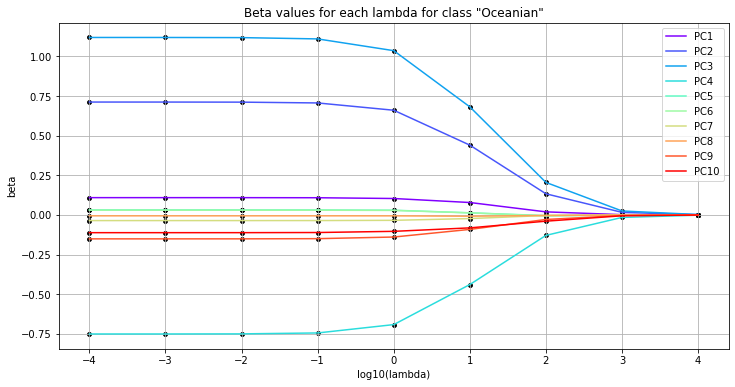

In [5]:
#Obtaining all beta matrices for each lambda value
B_arr = []
for lamb in lambs: 
    B = logistic_regression(x_train, Y, lamb, alpha, epochs)
    B_arr.append(B)    

plt_arr = np.zeros((labels.shape[0], len(lambs), x_train.shape[1]))   

#Reordering the values for easier plotting
for i, B in enumerate(B_arr):
    for j in range(1,B.shape[0]):
        for k in range(B.shape[1]):
            plt_arr[k, i, j - 1] = B[j, k]

#For each class...
for i, label in enumerate(labels):
    fig0, ax0 = plt.subplots(figsize=[12,6])
    
    #For each feature...
    for j in range(plt_arr[i].shape[1]):
        #Plot the beta values for all lambdas
        ax0.plot(lamb_log, plt_arr[i][:, j], label=f'PC{j+1}', color = colors[j])
        ax0.scatter(lamb_log, plt_arr[i][:, j], color = 'k', s = 15)
        
    ax0.set_title(f'Beta values for each lambda for class "{label}"')
    ax0.set_xlabel('log10(lambda)')
    ax0.set_ylabel('beta')
    ax0.legend(loc='upper right')
    ax0.grid()

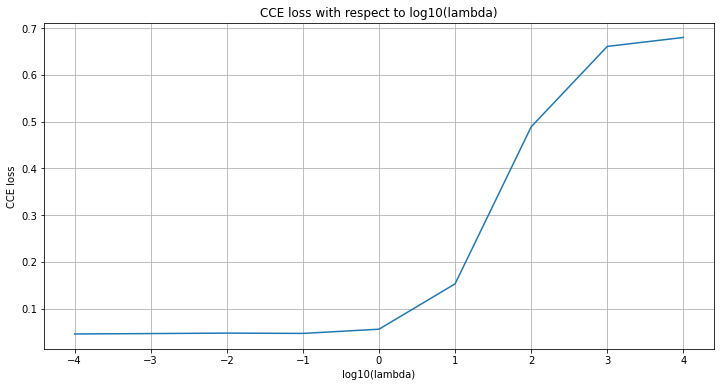

In [8]:
fig1, ax1 = plt.subplots(figsize=[12,6])
loss_arr = []

#Obtain the CCE for all lambda values
for lamb in lambs: 
    cv_CCE, B = k_fold_cv(x_train, y_train, 5, lamb, alpha, epochs)
    loss_arr.append(cv_CCE)

#Plot the values against the lambda values
ax1.plot(lamb_log, loss_arr)
ax1.set_title(f'CCE loss with respect to log10(lambda)')
ax1.set_xlabel('log10(lambda)')
ax1.set_ylabel('CCE loss')    
ax1.grid()

In [9]:
print(f'The lambda value that gives the lowest CCE loss is {lambs[loss_arr.index(min(loss_arr))]} with a CCE loss of {round(min(loss_arr), 4)}')

The lambda value that gives the lowest CCE loss is 0.0001 with a CCE loss of 0.0456


Although the lambda value that provides the lowest loss is 0.0001 (usually, but may vary), I feel as though the best lambda value overall may be 0 as it provides less complexity for very marginally worse performance.

In [22]:
#Using the above determined best lambda of 0 to find the best B matrix
B_best = logistic_regression(x_train, Y, 0, alpha, epochs)

#Find predicted probabilities to predict classes of test data
P = predict(B_best, x_test)

#Displaying probabilities and most likely class of each observation
for i in range(P.shape[0]):
    P_max = np.max(P[i])
    P_max_ind = np.where(P[i] == P_max)
    print(f'Observation {i+1} has probabilities:\n{labels}\n{P[i]}\nwith the most likely class being "{labels[P_max_ind[0][0]]}" with probability {round(P[i][P_max_ind[0][0]], 4)}\n\n\n')

Observation 1 has probabilities:
['African' 'EastAsian' 'European' 'NativeAmerican' 'Oceanian']
[0.00771427 0.00499705 0.00605737 0.00450704 0.97672427]
with the most likely class being "Oceanian" with probability 0.9767



Observation 2 has probabilities:
['African' 'EastAsian' 'European' 'NativeAmerican' 'Oceanian']
[0.00190357 0.00310784 0.00896294 0.98325467 0.00277098]
with the most likely class being "NativeAmerican" with probability 0.9833



Observation 3 has probabilities:
['African' 'EastAsian' 'European' 'NativeAmerican' 'Oceanian']
[0.01142053 0.03710957 0.93317682 0.00720137 0.01109172]
with the most likely class being "European" with probability 0.9332



Observation 4 has probabilities:
['African' 'EastAsian' 'European' 'NativeAmerican' 'Oceanian']
[0.93113146 0.00580621 0.00921661 0.00871367 0.04513205]
with the most likely class being "African" with probability 0.9311



Observation 5 has probabilities:
['African' 'EastAsian' 'European' 'NativeAmerican' 'Oceanian']
[0.

When looking at the observations with class label Unknown, the porbabilities of originating from the given regions are near anywhere from 93% to 100%. This means that these individuals display genetic features that are mostly associated with one region. However, the individuals with both Mexican and African American class labels have probabilities ranging from 35%-95%, suggesting that their region of origin is more inconsistent and uncertain. This makes sense, especially when looking at their assigned probabilities and class labels, when thinking about this in reference to recent history. This is because of the main ethnic groups involved with the colonization of the Americas. Mexicans usually display a combination of Native American and European genetic features according to the regression algorithm, which is historically accurate with the interactions between the two ethnic groups during Spanish colonialism in the Americas. African Americans, on the other hand, usually display a combination of European and African genetic features according to the regression algorithm. This also makes sense due to the proximity and interactions between the two groups during the slave trade throughout European colonization of the Americas.